In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm import tqdm

import numpy as np
import pandas as pd
import re, os, sys

import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
mpl.rcParams['pdf.fonttype'] = 42

import math

font_name = {'fontname':'Arial'}

plt.rcParams["font.family"] = "Arial"


In [113]:
# parameter settings

GPNotebook_dir = r"/Users/yingweihu/Documents/GitHub/GPNotebook"
data_name = "PDAC"

# working directory, wd
wd = os.path.join(GPNotebook_dir,"sample",data_name)
# input meta path: standardrized meta table
meta_path = os.path.join(wd,"meta/info.tsv")
# input expression matrix path
data_dir = os.path.join(wd,"data")
expr_path = os.path.join(data_dir,"PDA_JHU_GENCODEv34_nglycoform-peptide_matrix-abundances-MD_norm.tsv")

# create folders for generating results
result_dir = os.path.join(wd,"result")

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
    
tool_dir = os.path.join(result_dir,"GPNotebook")
if not os.path.exists(tool_dir):
    os.mkdir(tool_dir)
    
job_dir = os.path.join(tool_dir,"survival_analysis")
if not os.path.exists(job_dir):
    os.mkdir(job_dir)
    
out_z_data_path = os.path.join(job_dir,'z_data.tsv.joblib')
out_fig_UniCOX_path = os.path.join(job_dir, "univariate_cox_curve.svg")
out_data_UniCOX_path = os.path.join(job_dir, "univariate_cox_data.tsv")

# print file location and verify the file path
print("Parameters")
print(f'--meta {meta_path}',
     os.path.exists(meta_path))

print(f'--expr {expr_path}',
     os.path.exists(expr_path))
print(f'--output_idr {job_dir}',
     os.path.exists(job_dir))


# column name in meta table for event, 1 for dead, 0 for alive
e = 'VitalStatus'
# nan value: unknown
nan_value = 'Unknown'
# label for living
l = 'Living'
# label for death
d = 'Deceased'
# column name in meta table for survival days
days = 'SurvivalDays'

Parameters
--meta /Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/meta/info.tsv True
--expr /Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/data/PDA_JHU_GENCODEv34_nglycoform-peptide_matrix-abundances-MD_norm.tsv True
--output_idr /Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/result/GPNotebook/survival_analysis True


In [3]:
# load meta data
meta_df = pd.read_csv(meta_path,sep="\t")
meta_df.head(10)

,Sample,CaseID,VitalStatus,SurvivalDays,Age,Gender,DeathCause
0,C3L-00102.N,C3L-00102,Deceased,249.0,42,Male,pancreatic carcinoma
1,C3L-00189.N,C3L-00189,Deceased,1035.0,68,Female,pancreatic carcinoma
2,C3L-00277.N,C3L-00277,Deceased,610.0,69,Male,pancreatic carcinoma
3,C3L-00401.N,C3L-00401,Living,1228.0,62,Female,Unknown
4,C3L-00640.N,C3L-00640,Living,594.0,59,Female,Unknown
5,C3L-00819.N,C3L-00819,Deceased,602.0,74,Male,pancreatic carcinoma
6,C3L-00881.N,C3L-00881,Living,3.0,80,Male,Unknown
7,C3L-00928.N,C3L-00928,Deceased,761.0,58,Female,pancreatic carcinoma
8,C3L-01031.N,C3L-01031,Living,369.0,64,Female,Unknown
9,C3L-01036.N,C3L-01036,Living,765.0,64,Male,Unknown


In [4]:
sample_col = 'Sample'
event_col = 'VitalStatus'
days_col = 'SurvivalDays'
vital_d = dict(zip(meta_df[sample_col], meta_df[event_col]))
days_d = dict(zip(meta_df[sample_col],meta_df[days_col]))

In [5]:
n = 0

for index,row in meta_df.iterrows():
    sample = row['Sample']
    if re.search('\.T$',sample):
        n += 1
print(n)

135


In [6]:
# clean data for records with nan value of vital status and survival days
meta_df2 = meta_df[meta_df[e]!=nan_value]
meta_df2 = meta_df2[pd.notna(meta_df[days])]
meta_df2[e] =  meta_df2[e].map(lambda x: True if x == d else False)

<ipython-input-6-be06898b98e1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meta_df2 = meta_df2[pd.notna(meta_df[days])]


In [7]:
expr_df = pd.read_csv(expr_path,sep="\t",index_col=[0,1])
expr_df.head(2)

,,Intensity.Reference,PDA.Reference Sample 1,PDA.QC1,PDA.C3N-03884.T,PDA.C3L-00589.N,PDA.C3L-03123.N,PDA.C3L-01687.N,PDA.C3L-03123.T,PDA.C3L-01687.T,PDA.C3L-00589.T,...,PDA.C3L-03513.N,PDA.WU-PDA1.T,PDA.C3L-03514.N,PDA.C3L-03515.N,PDA.WU-pooled sample.T,PDA.C3L-07032.N,PDA.C3L-07033.N,PDA.C3L-07034.N,PDA.C3L-07035.N,PDA.C3L-07036.N
Sequence,Gene,,,,,,,,,,,,,,,,,,,,,
NDAGSYECEIQNPASANR-N5H5F1S0G0,CEACAM6|ENSG00000086548.9,10.0424015406,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
QNQCFYNSSYLNVQR-N5H6F0S3G0,ORM2|ENSG00000228278.4,14.2690205148,14.2690205148,None,14.6448483948,13.5886759597,14.2063481924,15.3512247882,15.1031540161,13.8818144061,13.5159572356,...,14.256315458,14.5026232524,13.4460562864,None,14.8404622968,10.7594304132,12.3594986346,13.4461720971,15.1377181047,13.8070677045


In [8]:
# use 105 tumor samples applied in the publication
samples_path = os.path.join(data_dir,"PDAC_samples.txt")

samples = []
with open(samples_path,"r") as f:
    samples = f.readlines()
    f.close()
samples = [i.strip() for i in samples]

In [9]:
expr_df2 = expr_df[samples]
expr_df2 = expr_df2.replace('None',np.nan)
expr_df2 = expr_df2.applymap(float)
expr_df2 = expr_df2.dropna()
expr_df2.shape

(1470, 105)

In [10]:
expr_df2.head(2)

,,PDA.C3N-01715.T,PDA.C3N-03426.T,PDA.C3N-00198.T,PDA.C3N-01380.T,PDA.C3N-01388.T,PDA.C3L-03388.T,PDA.C3N-02589.T,PDA.C3L-03356.T,PDA.C3N-02944.T,PDA.C3N-00436.T,...,PDA.C3L-01031.T,PDA.C3N-01167.T,PDA.C3L-01971.T,PDA.C3L-02604.T,PDA.C3L-00277.T,PDA.C3L-01328.T,PDA.C3L-03639.T,PDA.C3N-04282.T,PDA.C3L-04072.T,PDA.C3L-02613.T
Sequence,Gene,,,,,,,,,,,,,,,,,,,,,
ADGTVNQIEGEATPVNLTEPAK-N4H5F1S1G0,APOD|ENSG00000189058.9,16.84712,16.908465,16.748654,17.265055,17.260076,17.014516,17.241551,16.337189,16.531157,16.574780,...,16.842759,17.259819,17.302240,17.400414,17.266451,16.588498,17.360629,17.508588,16.573547,16.995179
EVNDTLLVNELK-N5H5F1S1G0,POSTN|ENSG00000133110.15,16.59281,17.907177,18.772012,17.468563,17.778783,16.157428,18.201598,17.157913,18.458719,18.214289,...,17.776094,17.373620,18.005921,17.764340,19.104141,17.160057,16.553800,16.555843,15.797861,16.335483


In [11]:
row_names = []
from scipy.stats import variation

# generate z-transformed matrix, and filter out any peptides CV less than 0.25

rows = []
for index,row in expr_df2.iterrows():
    data = list(row)
    cv = variation([np.power(2,i) for i in data])

    if cv < 0.25:
        continue
    
    mean = np.mean(data)
    std_dev = np.std(data)
    z_score = [(i-mean)/std_dev for i in data]
    rows.append(z_score)
    row_names.append(index)

z_df = pd.DataFrame(rows,index = row_names,columns=expr_df2.columns.values)

z_df.shape

(1462, 105)

In [12]:
z_df.head(2)

,PDA.C3N-01715.T,PDA.C3N-03426.T,PDA.C3N-00198.T,PDA.C3N-01380.T,PDA.C3N-01388.T,PDA.C3L-03388.T,PDA.C3N-02589.T,PDA.C3L-03356.T,PDA.C3N-02944.T,PDA.C3N-00436.T,...,PDA.C3L-01031.T,PDA.C3N-01167.T,PDA.C3L-01971.T,PDA.C3L-02604.T,PDA.C3L-00277.T,PDA.C3L-01328.T,PDA.C3L-03639.T,PDA.C3N-04282.T,PDA.C3L-04072.T,PDA.C3L-02613.T
"(ADGTVNQIEGEATPVNLTEPAK-N4H5F1S1G0, APOD|ENSG00000189058.9)",-0.352471,-0.225557,-0.556182,0.512180,0.501879,-0.006151,0.463553,-1.407448,-1.006155,-0.915905,...,-0.361492,0.501347,0.589110,0.792219,0.515068,-0.887524,0.709910,1.016017,-0.918455,-0.046157
"(EVNDTLLVNELK-N5H5F1S1G0, POSTN|ENSG00000133110.15)",-1.394212,0.211637,1.268263,-0.324247,0.054769,-1.926146,0.571351,-0.703789,0.885492,0.586856,...,0.051484,-0.440245,0.332279,0.037123,1.674047,-0.701168,-1.441874,-1.439377,-2.365453,-1.708605


In [13]:
z_df2 = z_df.T

In [14]:
z_df2.index = [re.sub('PDA.','',i) for i in z_df2.index]

In [15]:
z_df2.head(2)

,"(ADGTVNQIEGEATPVNLTEPAK-N4H5F1S1G0, APOD|ENSG00000189058.9)","(EVNDTLLVNELK-N5H5F1S1G0, POSTN|ENSG00000133110.15)","(SINVTGQGFSLIQR-N2H9F0S0G0, PLXNB2|ENSG00000196576.15)","(SLTQGSLIVGDLAPVNGTSQGK-N4H5F2S0G0, HSPG2|ENSG00000142798.20)","(VVANGTGTQGQLK-N2H5F0S0G0, GUSB|ENSG00000169919.17)","(DQCIVDDITYNVNDTFHK-N3H4F1S0G0, FN1|ENSG00000115414.20)","(MLEAYNLTEK-N2H8F0S0G0, COL12A1|ENSG00000111799.21)","(IADTNITSIPQGLPPSLTELHLDGNK-N4H5F0S1G0, DCN|ENSG00000011465.17)","(LHINHNNLTESVGPLPK-N4H5F2S0G0, LUM|ENSG00000139329.5)","(LHINHNNLTESVGPLPK-N4H5F1S2G0, LUM|ENSG00000139329.5)",...,"(LSDTTSQSNSTAK-N2H8F0S0G0, LAMB1|ENSG00000091136.14)","(CATPHGDNASLEATFVK-N5H6F1S2G0, FBLN1|ENSG00000077942.19)","(ALPQPQNVTSLLGCTH-N6H3F1S2G0, HPX|ENSG00000110169.11)","(FQAFANGSLLIPDFGK-N3H5F1S1G0, ISLR|ENSG00000129009.13)","(LGLSFNSISAVDNGSLANTPHLR-N5H4F1S1G0, DCN|ENSG00000011465.17)","(TTLVDNNTWNNSHIALVGK-N2H8F0S0G0, STT3B|ENSG00000163527.10)","(NETLALPAESK-N4H5F1S1G0, ABI3BP|ENSG00000154175.17)","(EGPEQVIPINSGDLFVHPLWNR-N5H5F2S0G0, CELA3B|ENSG00000219073.8)","(NNSIPDK-N2H6F0S0G0, MFGE8|ENSG00000140545.15)","(SENASLVLSSSNQK-N2H7F0S0G0, ITGA1|ENSG00000213949.10)"
C3N-01715.T,-0.352471,-1.394212,1.081268,-0.953489,-0.605735,-0.274263,1.171881,-0.867781,0.981550,0.014858,...,0.395884,-0.059528,0.246236,-1.776201,-0.536928,1.087566,-2.068157,0.132239,-1.029283,-1.608522
C3N-03426.T,-0.225557,0.211637,-1.815535,-0.881718,0.708935,0.814634,-0.104783,-1.755147,-1.093348,-1.504497,...,-1.878902,-1.907970,-0.793549,-1.828400,-0.518092,-0.505203,-2.146305,-0.100299,0.160715,-1.386537


In [16]:
z_df2['T'] = z_df2.index.map(days_d)
z_df2['E'] = z_df2.index.map(vital_d)

In [17]:
var_d = dict()
for index,name in enumerate(z_df2.columns.values):
    value = 'X' + str(index)
    key = name
    if name in ['E','T']:
        var_d[key] = key
    else:
        var_d[key] = value

z_df2.columns = [var_d.get(i) for i in z_df2.columns.values]

In [18]:
var_d_rev = dict()
for i in var_d:
    var_d_rev[var_d[i]] = i

In [19]:
z_df2.head(2)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X1454,X1455,X1456,X1457,X1458,X1459,X1460,X1461,T,E
C3N-01715.T,-0.352471,-1.394212,1.081268,-0.953489,-0.605735,-0.274263,1.171881,-0.867781,0.981550,0.014858,...,0.246236,-1.776201,-0.536928,1.087566,-2.068157,0.132239,-1.029283,-1.608522,108.0,Deceased
C3N-03426.T,-0.225557,0.211637,-1.815535,-0.881718,0.708935,0.814634,-0.104783,-1.755147,-1.093348,-1.504497,...,-0.793549,-1.828400,-0.518092,-0.505203,-2.146305,-0.100299,0.160715,-1.386537,122.0,Deceased


In [20]:
z_df2 = z_df2[pd.notna(z_df2['T'])]
z_df2 = z_df2[pd.notna(z_df2['E'])]

In [21]:
z_df2['E'] = z_df2['E'].map(lambda i: True if i =='Deceased' else False)

In [111]:
import joblib

In [112]:
z_df3 = z_df2.copy(deep=True)
z_df3.columns = [var_d_rev.get(i) for i in z_df3.columns.values]
joblib.dump(z_df3, out_z_data_path)

['/Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/result/GPNotebook/survival_analysis/z_data.tsv.joblib']

In [109]:
z_df3.head(2)

,"(ADGTVNQIEGEATPVNLTEPAK-N4H5F1S1G0, APOD|ENSG00000189058.9)","(EVNDTLLVNELK-N5H5F1S1G0, POSTN|ENSG00000133110.15)","(SINVTGQGFSLIQR-N2H9F0S0G0, PLXNB2|ENSG00000196576.15)","(SLTQGSLIVGDLAPVNGTSQGK-N4H5F2S0G0, HSPG2|ENSG00000142798.20)","(VVANGTGTQGQLK-N2H5F0S0G0, GUSB|ENSG00000169919.17)","(DQCIVDDITYNVNDTFHK-N3H4F1S0G0, FN1|ENSG00000115414.20)","(MLEAYNLTEK-N2H8F0S0G0, COL12A1|ENSG00000111799.21)","(IADTNITSIPQGLPPSLTELHLDGNK-N4H5F0S1G0, DCN|ENSG00000011465.17)","(LHINHNNLTESVGPLPK-N4H5F2S0G0, LUM|ENSG00000139329.5)","(LHINHNNLTESVGPLPK-N4H5F1S2G0, LUM|ENSG00000139329.5)",...,"(ALPQPQNVTSLLGCTH-N6H3F1S2G0, HPX|ENSG00000110169.11)","(FQAFANGSLLIPDFGK-N3H5F1S1G0, ISLR|ENSG00000129009.13)","(LGLSFNSISAVDNGSLANTPHLR-N5H4F1S1G0, DCN|ENSG00000011465.17)","(TTLVDNNTWNNSHIALVGK-N2H8F0S0G0, STT3B|ENSG00000163527.10)","(NETLALPAESK-N4H5F1S1G0, ABI3BP|ENSG00000154175.17)","(EGPEQVIPINSGDLFVHPLWNR-N5H5F2S0G0, CELA3B|ENSG00000219073.8)","(NNSIPDK-N2H6F0S0G0, MFGE8|ENSG00000140545.15)","(SENASLVLSSSNQK-N2H7F0S0G0, ITGA1|ENSG00000213949.10)",T,E
C3N-01715.T,-0.352471,-1.394212,1.081268,-0.953489,-0.605735,-0.274263,1.171881,-0.867781,0.981550,0.014858,...,0.246236,-1.776201,-0.536928,1.087566,-2.068157,0.132239,-1.029283,-1.608522,108.0,True
C3N-03426.T,-0.225557,0.211637,-1.815535,-0.881718,0.708935,0.814634,-0.104783,-1.755147,-1.093348,-1.504497,...,-0.793549,-1.828400,-0.518092,-0.505203,-2.146305,-0.100299,0.160715,-1.386537,122.0,True


In [22]:

from lifelines import CoxPHFitter

# run COX model for any individual glycopeptides

rows = []
for i in tqdm(list(z_df2.columns.values)[:-2]):
    cph = CoxPHFitter()
 
    cph.fit(z_df2, 'T', event_col='E', formula='{}'.format(i))
    t = cph.summary
    rows.append(t)

rdf = pd.concat(rows)

100%|██████████| 1462/1462 [1:25:38<00:00,  3.51s/it]    


In [23]:
rdf.head(2)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
X0,-0.080503,0.922652,0.125911,-0.327283,0.166278,0.720880,1.180901,0.0,-0.639364,0.522586,0.936258
X1,-0.256571,0.773700,0.146377,-0.543464,0.030322,0.580733,1.030787,0.0,-1.752811,0.079635,3.650462


In [36]:
rdf['IGP'] = [var_d_rev.get(i) for i in rdf.index]

In [37]:
rdf[rdf['p']<0.05].shape

(208, 13)

In [44]:
rdf2 = rdf.sort_values(['p']).iloc[:20,:]
rdf2.head(2)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),p_adj,IGP
covariate,,,,,,,,,,,,,
X534,-0.625197,0.535156,0.156131,-0.931208,-0.319186,0.394077,0.726741,0.0,-4.004310,0.000062,13.972754,0.0658,"(LDAFFALEGFPTEPNSSSR-N4H5F1S1G0, SOD3|ENSG0000..."
X108,0.533833,1.705456,0.140799,0.257871,0.809795,1.294172,2.247446,0.0,3.791441,0.000150,12.704909,0.0658,"(GNFSTEGCGCVCEPGWK-N5H6F1S1G0, TNC|ENSG0000004..."


In [57]:
rdf2.to_csv(out_data_UniCOX_path,sep="\t",index=True)

In [114]:
joblib.dump(rdf2,out_data_UniCOX_path + "joblib")

['/Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/result/GPNotebook/survival_analysis/univariate_cox_data.tsvjoblib']

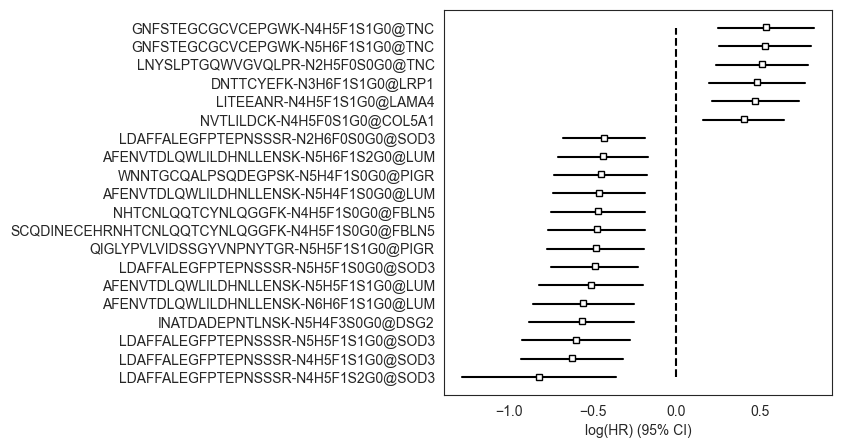

In [49]:
import matplotlib.pyplot as plt


# Define x and y coordinates of the square
x = [1]
y = [1]

fig, ax = plt.subplots(figsize=(5,5),dpi=100)
# Plot the square
n = 0
rdf2 = rdf2.sort_values('coef')
for index,row in rdf2.iterrows():
   
    
    x = row['coef']
    y = n
    plt.plot(x, y+0.035, marker='s', markersize=5,markerfacecolor='white', markeredgecolor='black',zorder=2)
    
    x1 = row['coef lower 95%']
    x2 = row['coef upper 95%']
    
    plt.plot([x1,x2],[y,y],color='k',zorder=1)
    

    n += 1
    
plt.plot([0,0],[0,n-1],linestyle='--',color='k')

yticklabels = [f'{i[0]}@{i[1].split("|")[0]}' for i in rdf2['IGP']]
# t = ax.set_yticklabels(yticklabels)

# plt.yticks([0, 10, 20, 30, 40, 50,60], ['$0', '$10', '$20', '$30', '$40', '$50','$60'])

t = plt.yticks([i for i in range(len(yticklabels))],yticklabels)


t = plt.xlabel('log(HR) (95% CI)')

plt.savefig(out_fig_UniCOX_path,format="SVG",bbox_inches='tight')

# Estimate Time-dependent Area under the ROC

In [59]:
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sksurv.datasets import load_flchain, load_gbsg2
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [52]:
aux = [(row['E'],row['T']) for index,row in z_df2.iterrows()]

#Structured array
y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [56]:
rdf2.index

Index(['X366', 'X534', 'X24', 'X360', 'X1009', 'X521', 'X92', 'X590', 'X139',
       'X1359', 'X542', 'X62', 'X710', 'X957', 'X340', 'X1240', 'X1014',
       'X458', 'X108', 'X75'],
      dtype='object', name='covariate')

In [58]:
#%%
X = z_df2.drop(['E','T'],axis=1)
X = X.loc[:,list(rdf2.index)]

In [64]:
#%%
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y["Status"], random_state=42
)

In [65]:
y_events = y_train[y_train['Status']]
train_min, train_max = y_events["Survival_in_days"].min(), y_events["Survival_in_days"].max()

y_events = y_test[y_test['Status']]
test_min, test_max = y_events["Survival_in_days"].min(), y_events["Survival_in_days"].max()

assert train_min <= test_min < test_max < train_max, \
    "time range or test data is not within time range of training data."

In [66]:
train_min,test_min,test_max,train_max

(1.0, 68.0, 810.0, 1001.0)

In [67]:
times = np.percentile(y["Survival_in_days"], np.linspace(20, 80, 15))
print(times)

[228.         246.94285714 264.85714286 290.8        304.31428571
 332.25714286 355.08571429 369.         402.51428571 454.68571429
 467.02857143 569.57142857 622.57142857 666.05714286 700.        ]


In [68]:
x_train.columns =  [var_d_rev.get(i) for i in x_train.columns.values]
x_test.columns =  [var_d_rev.get(i) for i in x_test.columns.values]

In [89]:
x_test.head(2)

,"(LDAFFALEGFPTEPNSSSR-N4H5F1S2G0, SOD3|ENSG00000109610.6)","(LDAFFALEGFPTEPNSSSR-N4H5F1S1G0, SOD3|ENSG00000109610.6)","(LDAFFALEGFPTEPNSSSR-N5H5F1S1G0, SOD3|ENSG00000109610.6)","(INATDADEPNTLNSK-N5H4F3S0G0, DSG2|ENSG00000046604.13)","(AFENVTDLQWLILDHNLLENSK-N6H6F1S1G0, LUM|ENSG00000139329.5)","(AFENVTDLQWLILDHNLLENSK-N5H5F1S1G0, LUM|ENSG00000139329.5)","(LDAFFALEGFPTEPNSSSR-N5H5F1S0G0, SOD3|ENSG00000109610.6)","(QIGLYPVLVIDSSGYVNPNYTGR-N5H5F1S1G0, PIGR|ENSG00000162896.6)","(SCQDINECEHRNHTCNLQQTCYNLQGGFK-N4H5F1S0G0, FBLN5|ENSG00000140092.14)","(NHTCNLQQTCYNLQGGFK-N4H5F1S0G0, FBLN5|ENSG00000140092.14)","(AFENVTDLQWLILDHNLLENSK-N5H4F1S0G0, LUM|ENSG00000139329.5)","(WNNTGCQALPSQDEGPSK-N5H4F1S0G0, PIGR|ENSG00000162896.6)","(AFENVTDLQWLILDHNLLENSK-N5H6F1S2G0, LUM|ENSG00000139329.5)","(LDAFFALEGFPTEPNSSSR-N2H6F0S0G0, SOD3|ENSG00000109610.6)","(NVTLILDCK-N4H5F0S1G0, COL5A1|ENSG00000130635.16)","(LITEEANR-N4H5F1S1G0, LAMA4|ENSG00000112769.20)","(DNTTCYEFK-N3H6F1S1G0, LRP1|ENSG00000123384.14)","(LNYSLPTGQWVGVQLPR-N2H5F0S0G0, TNC|ENSG00000041982.16)","(GNFSTEGCGCVCEPGWK-N5H6F1S1G0, TNC|ENSG00000041982.16)","(GNFSTEGCGCVCEPGWK-N4H5F1S1G0, TNC|ENSG00000041982.16)"
C3L-00102.T,0.555829,1.017763,1.691739,0.276294,0.600025,0.404877,0.714349,-0.688899,0.885582,0.635666,0.125249,0.417846,0.037261,0.876314,-0.579093,1.381920,0.134280,-0.617953,-0.161971,-0.497000
C3L-00599.T,0.904881,2.164579,1.557850,1.160359,0.710280,0.149155,2.405695,0.996843,2.315712,3.041454,0.747855,-0.129346,0.647329,2.371785,-0.705897,-1.508122,-4.165694,-0.459058,-2.619296,-1.890075


In [91]:
y_test

array([( True,  249.), (False, 1189.), ( True,  225.), (False,   78.),
       ( True,  602.), ( True,  454.), ( True,   70.), ( True,  701.),
       ( True,  810.), ( True,  632.), ( True,  457.), (False,  466.),
       (False,   32.), ( True,   68.), ( True,  469.), ( True,  122.),
       (False,  369.), (False,  313.), (False,  426.), (False,  259.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

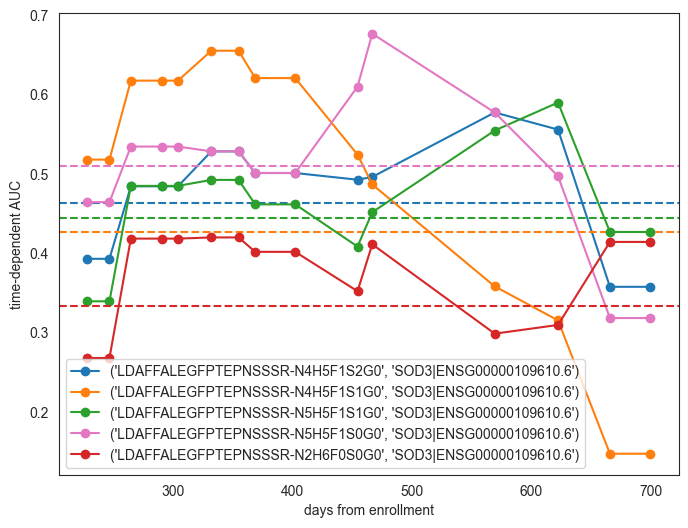

In [102]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

fig,ax = plt.subplots(figsize=(8,6))
    
for i, col in enumerate(x_test.columns.values):
#     print(col)
    if re.search('SOD3',col[1]):
        plot_cumulative_dynamic_auc(np.array(x_test.iloc[:, i]), 
                                    col, 
                                    color="C{}".format(i))
        ret = concordance_index_ipcw(y_train, y_test, np.array(x_test.iloc[:, i]), tau=times[-1])
    
# plt.legend(bbox_to_anchor=(1.25, 1))

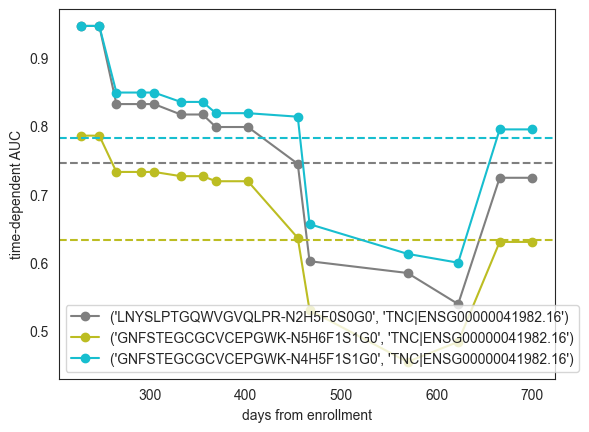

In [103]:
for i, col in enumerate(x_test.columns.values):
#     print(col)
    if re.search('TNC',col[1]):
        plot_cumulative_dynamic_auc(np.array(x_test.iloc[:, i]), 
                                    col, 
                                    color="C{}".format(i))
        ret = concordance_index_ipcw(y_train, y_test, np.array(x_test.iloc[:, i]), tau=times[-1])